<a href="https://colab.research.google.com/github/tomek-l/fire/blob/master/19_07_06_CAM_grad_on_mispredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=False)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
from keras.models import load_model
model = load_model('/gdrive/My Drive/FireVideo/models/VGG_monolth_30epochs.h5')

Using TensorFlow backend.
W0707 16:16:31.902106 140376789100416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0707 16:16:31.926537 140376789100416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0707 16:16:31.957842 140376789100416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0707 16:16:32.385771 140376789100416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0707 16:16:32.387018 14

In [4]:
from skimage import transform,io
import numpy as np
import os
img_list = []

NEG_DIR = '/gdrive/My Drive/FireVideo/binary_dataset/validation/negatives/'
POS_DIR = '/gdrive/My Drive/FireVideo/binary_dataset/validation/negatives/'

neg_images = np.array([io.imread(NEG_DIR+f) for f in os.listdir(NEG_DIR)])
pos_images = np.array([io.imread(POS_DIR+f) for f in os.listdir(POS_DIR)])

negatives_tensor = np.array([transform.resize(i, (150,150), mode='symmetric') for i in neg_images])
positives_tensor = np.array([transform.resize(i, (150,150), mode='symmetric') for i in pos_images])

print(negatives_tensor.shape)
print(positives_tensor.shape)

(98, 150, 150, 3)
(98, 150, 150, 3)


# Let's find the false positives and negatives

In [5]:
positives_tensor.shape

(98, 150, 150, 3)

In [0]:
pred_negatives = model.predict(negatives_tensor)
pred_positives = model.predict(positives_tensor)

In [7]:

false_positives = []
for idx, pred in enumerate(pred_negatives):
  if pred > 0.5:
    false_positives.append(negatives_tensor[idx])
    
false_positives_tensor = np.array(false_positives)

print(false_positives_tensor.shape)

(6, 150, 150, 3)


In [8]:

false_negatives = []
for idx, pred in enumerate(pred_positives):
  if pred > 0.5:
    false_negatives.append(positives_tensor[idx])
    
false_negatives_tensor = np.array(false_negatives)

print(false_negatives_tensor.shape)

(6, 150, 150, 3)


In [9]:
#Build graph for CAM-grad process
import keras.backend as K

binary_fire_output = model.output
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(model.output, last_conv_layer.output)[0]
print(grads)
pooled_grads = K.mean(grads, axis=(0, 1, 2))
print(pooled_grads)

Tensor("gradients/block5_pool/MaxPool_grad/MaxPoolGrad:0", shape=(?, 9, 9, 512), dtype=float32)
Tensor("Mean:0", shape=(512,), dtype=float32)


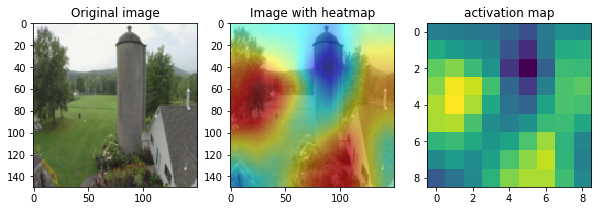

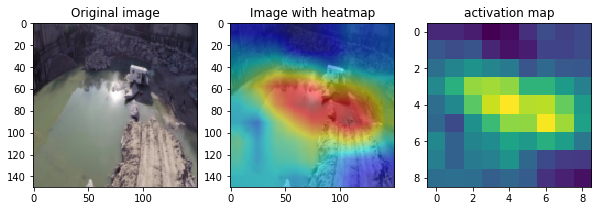

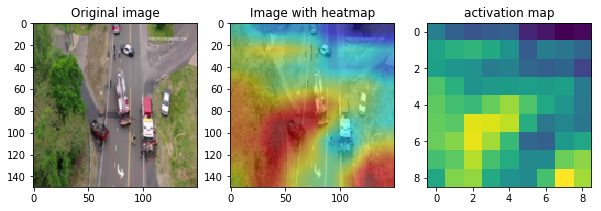

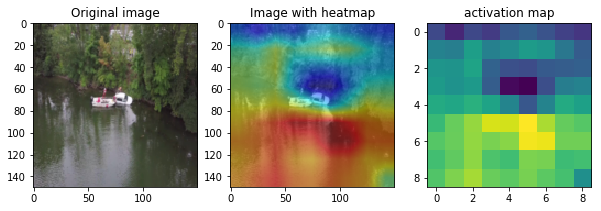

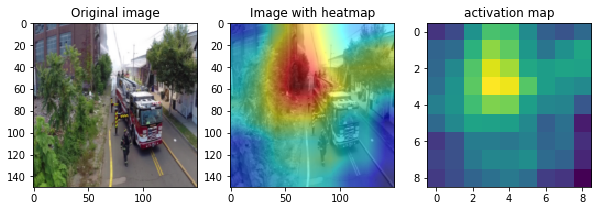

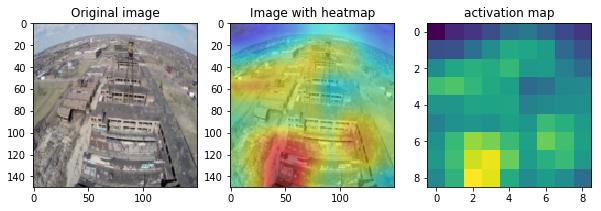

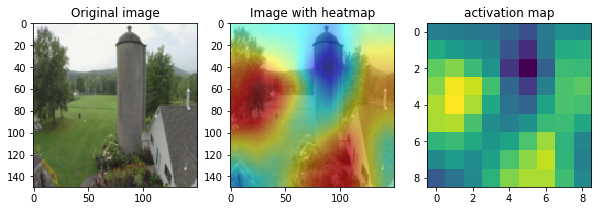

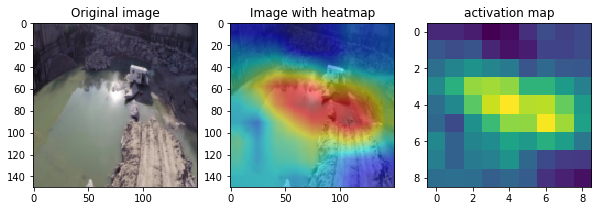

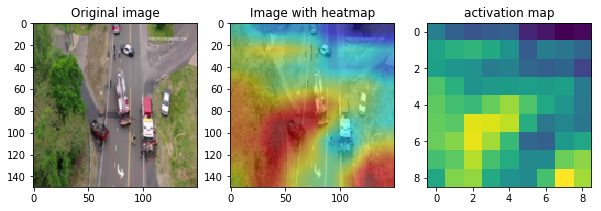

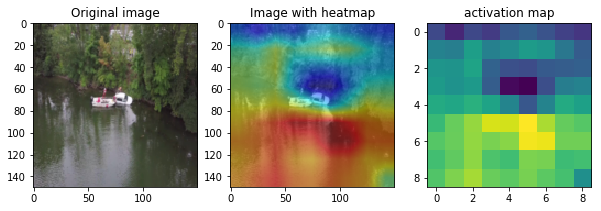

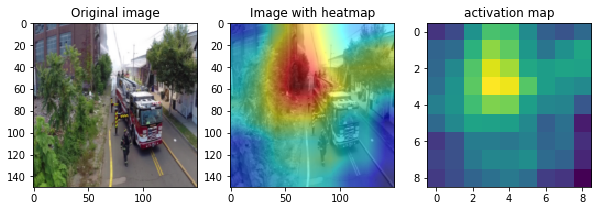

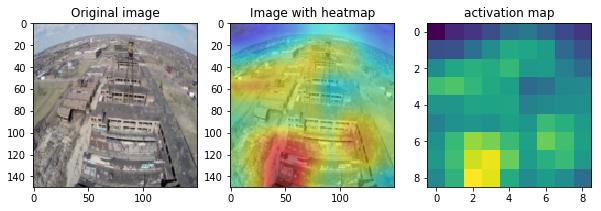

In [10]:
import os
import cv2

for ten in [false_negatives_tensor, false_positives_tensor]:
  for arr in ten:

    img = np.array(255*arr, dtype=np.uint8)

    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([np.expand_dims(arr, axis=0)])
    for i in range(512):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    am = np.mean(conv_layer_output_value, axis=-1) #(activation map)

    am_amplitude = np.max(am)-np.min(am)
    am_min = np.min(am)

    heatmap = (am+np.abs(am_min))/am_amplitude

    grayimg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    grayimg = cv2.cvtColor(grayimg, cv2.COLOR_GRAY2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = np.uint8(0.5* heatmap + 0.5* grayimg)  
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(10, 5))
    ax1.imshow(img)
    ax1.set_title('Original image')
    ax2.imshow(superimposed_img)  
    ax2.set_title('Image with heatmap')
    ax3.set_title('activation map')
    ax3.imshow(am)

    plt.show()